In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

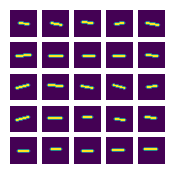

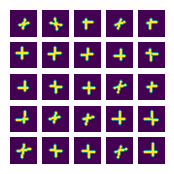

In [2]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [3]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #6273

X_text: "31-36" = y_text: "-5 "


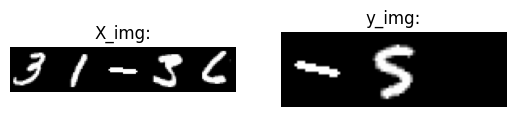

Query #1165

X_text: "5-82 " = y_text: "-77"


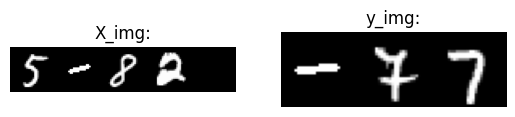

Query #8336

X_text: "41+68" = y_text: "109"


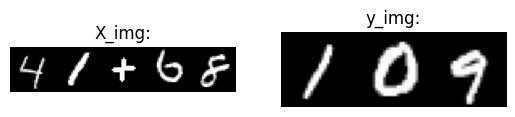

Query #5704

X_text: "28+52" = y_text: "80 "


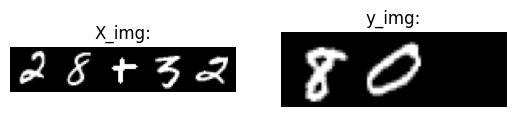

Query #1972

X_text: "9+86 " = y_text: "95 "


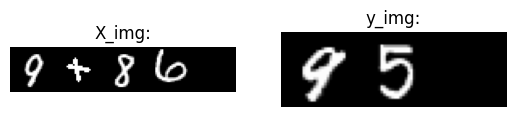

Query #3220

X_text: "16+10" = y_text: "26 "


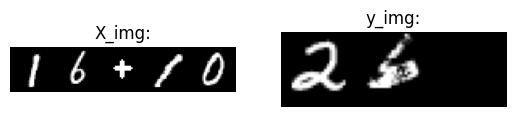

Query #4725

X_text: "23-62" = y_text: "-39"


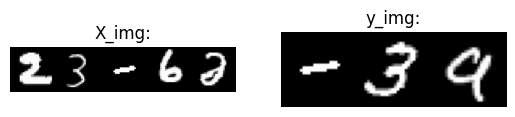

Query #2450

X_text: "12+25" = y_text: "37 "


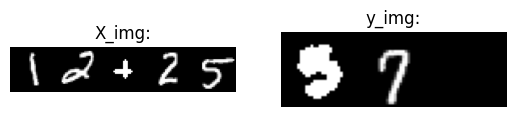

Query #293

X_text: "1-46 " = y_text: "-45"


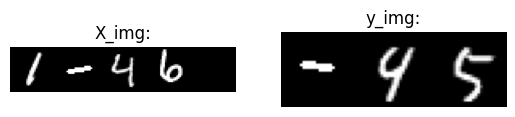

Query #7427

X_text: "37-13" = y_text: "24 "


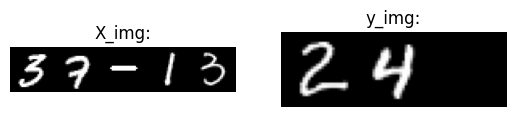

In [4]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


In [6]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

c:\Users\sajav\anaconda3\envs\un\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.3118 - loss: 2.1197 - val_accuracy: 0.4226 - val_loss: 1.6513
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4434 - loss: 1.5598 - val_accuracy: 0.4767 - val_loss: 1.4008
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5167 - loss: 1.3356 - val_accuracy: 0.5580 - val_loss: 1.2220
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5554 - loss: 1.2217 - val_accuracy: 0.5887 - val_loss: 1.1503
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5845 - loss: 1.1403 - val_accuracy: 0.5944 - val_loss: 1.1063
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6046 - loss: 1.0816 - val_accuracy: 0.6145 - val_loss: 1.0456
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6197 - loss: 1.0366 - val_accuracy: 0.6307 - val_loss: 0.9931
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6297 - loss: 0.9966 - val_accu

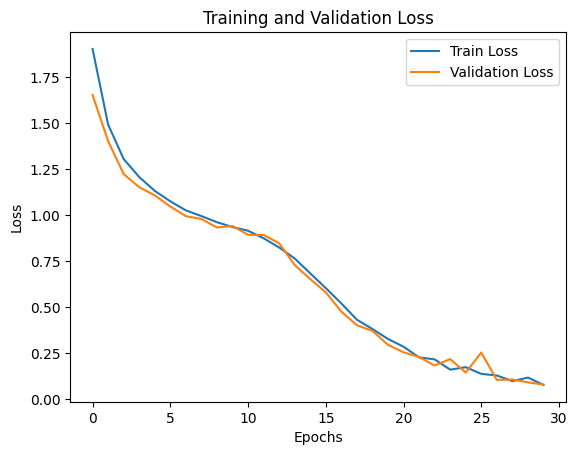

In [7]:
# Build the model
text2text_model = build_text2text_model()

# One-hot encode the labels for training
X_text_onehot = encode_labels(X_text, max_len=max_query_length)
y_text_onehot = encode_labels(y_text, max_len=max_answer_length)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_text_onehot, y_text_onehot, test_size=0.2, random_state=42
)

# Add Early Stopping to monitor validation loss
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = text2text_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,        # Maximum number of epochs to train
    batch_size=64,    # Batch size for training
    callbacks=[early_stop]
)

# Plot the training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [17]:
# the model
def build_image2text_model():
    model = tf.keras.Sequential()

    # Encoder: Convolutional LSTM with fewer filters
    model.add(ConvLSTM2D(
        filters=32,  # Reduced filters
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(max_query_length, 28, 28, 1),
        return_sequences=False
    ))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.3))

    # Decoder: LSTM with fewer units
    model.add(RepeatVector(max_answer_length))
    model.add(LSTM(128, return_sequences=True))  # Reduced units
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    return model


In [ ]:
# Custom function to augment sequence data
def augment_sequence(X, datagen):
    """
    Augments a sequence of images using ImageDataGenerator.

    Args:
    - X: Input image sequence of shape [samples, timesteps, height, width, channels].
    - datagen: An instance of ImageDataGenerator.

    Returns:
    - Augmented data of the same shape as X.
    """
    augmented_X = np.empty_like(X)  # Placeholder for augmented data

    for t in range(X.shape[1]):  # Loop over timesteps
        # Extract data for this timestep
        timestep_data = X[:, t, :, :, :]  
        
        # Augment this timestep's data
        augmented_timestep = datagen.flow(
            timestep_data, batch_size=X.shape[0], shuffle=False
        ).__next__()  # Use __next__() to fetch the batch
        
        # Store the augmented data
        augmented_X[:, t, :, :, :] = augmented_timestep

    return augmented_X


# Define the data augmentation pipeline
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Apply augmentation to the training images
X_train_augmented = augment_sequence(X_train, datagen)




In [36]:
from tensorflow.keras.datasets import mnist

# Load MNIST dataset directly
(X_train, y_train), (X_test, y_test) = mnist.load_data()


In [37]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Example function to generate text-based queries
def generate_text_queries():
    queries = []
    answers = []
    for _ in range(20000):  # Generate 20,000 examples
        num1 = np.random.randint(10, 100)  # Two-digit integer
        num2 = np.random.randint(10, 100)
        operator = np.random.choice(['+', '-'])
        
        query = f"{num1:02d}{operator}{num2:02d}"
        answer = str(eval(query))  # Calculate result
        
        queries.append(query)
        answers.append(answer)
    
    return queries, answers

# Generate text queries and encode as one-hot
queries, answers = generate_text_queries()

# Encode queries and answers into one-hot representations
char_set = '0123456789+- '  # 13 unique characters
char_to_index = {char: idx for idx, char in enumerate(char_set)}

def encode_sequence(sequence, maxlen=5):
    encoded = np.zeros((len(sequence), maxlen, len(char_set)))
    for i, seq in enumerate(sequence):
        for j, char in enumerate(seq):
            encoded[i, j, char_to_index[char]] = 1
    return encoded

X_text = encode_sequence(queries, maxlen=5)
y_text = encode_sequence(answers, maxlen=3)  # Answers are 3 characters long

# Split into train and validation sets
split_idx = int(0.8 * len(X_text))
X_train_text, X_val_text = X_text[:split_idx], X_text[split_idx:]
y_train_text, y_val_text = y_text[:split_idx], y_text[split_idx:]


In [39]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler

# Build a more regularized model
def build_regularized_image_to_text_model():
    model = Sequential()

    # Encoder with ConvLSTM2D
    model.add(ConvLSTM2D(
        filters=8,  # Fewer filters
        kernel_size=(3, 3),
        activation='tanh',
        padding='same',
        return_sequences=False,
        input_shape=(max_query_length, 28, 28, 1)
    ))
    model.add(Flatten())
    model.add(Dropout(0.4))  # Higher dropout for regularization

    # Decoder
    model.add(RepeatVector(max_answer_length))
    model.add(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01)))  # Reduced units, added L2 regularization
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    return model

# Learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch > 5:
        return lr * 0.5
    return lr

# Train the refined model
regularized_model = build_regularized_image_to_text_model()
history = regularized_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=128,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        LearningRateScheduler(lr_schedule)
    ]
)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss (Refined Model)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluate the model
evaluate_optimized_model(regularized_model, X_test, y_test)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_15 (ConvLSTM2D)     │ (None, 28, 28, 8)      │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_17 (RepeatVector) │ (None, 3, 6272)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 3, 32)          │       807,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 3, 13)          │           429 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 810,093 (3.09 MB)

 Trainable params: 810,093 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_17_1/Cast:0", shape=(None, 28, 28), dtype=float32). Expected shape (None, 5, 28, 28, 1), but input has incompatible shape (None, 28, 28)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 28, 28), dtype=uint8)
  • training=True
  • mask=None